# Indycar LSTM Anomaly Detection for Vehicle Speed

This code is tested with tensorflow-gpu 2.1

In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
client = MongoClient("put-mongodb-connection-string-here")
# database
db = client["indycar"]

# print collections(tables) in the indycar database
print(db.list_collection_names())

['laps', 'system.indexes', 'cars', 'telemetry', 'pitstop']


In [3]:
telemetry= db["telemetry"]

In [4]:
first_5 = telemetry.find({}).limit(5)

for rec in first_5:
    print(rec)
    
del first_5

{'_id': ObjectId('5d9cdc66d6468701d4b7863b'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '21', 'time_of_day_long': 58980010, 'time_of_day': '16:23:00.010', 'engine_speed': 3297.0, 'lap_distance': 2703.21, 'throttle': 4.0, 'vehicle_speed': 62.16, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863c'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '50', 'time_of_day_long': 58980019, 'time_of_day': '16:23:00.019', 'engine_speed': 5187.0, 'lap_distance': 1873.8, 'throttle': 20.0, 'vehicle_speed': 63.0, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863d'), 'file': 'eRPGenerator_TGMLP_20170528_Indianapolis500_Race.log', 'car_number': '63', 'time_of_day_long': 58980023, 'time_of_day': '16:23:00.023', 'engine_speed': 4914.0, 'lap_distance': 1822.53, 'throttle': 73.0, 'vehicle_speed': 58.0, 'series': 'Indy500', 'year': '2017'}
{'_id': ObjectId('5d9cdc66d6468701d4b7863e'), '

In [5]:
car_numbers_2017 = list(telemetry.find({'year':'2017', 'series':'Indy500'},
                                       {"car_number":1, "_id":0}).distinct("car_number"))
print(car_numbers_2017)

car_numbers_2018 = list(telemetry.find({'year':'2018', 'series':'Indy500'},
                                       {"car_number":1, "_id":0}).distinct("car_number"))
print(car_numbers_2018)

['21', '50', '63', '77', '1', '2', '4', '8', '9', '11', '12', '18', '19', '20', '24', '40', '44', '88', '98', '912', '916', '0', '15', '28', '911', '10', '14', '26', '29', '913', '7', '17', '22', '27', '3', '83', '5', '16']
['19', '22', '23', '24', '26', '27', '29', '32', '33', '59', '60', '64', '88', 'S1', 'S3', '1', '4', '6', '7', '10', '13', '14', '15', '17', '18', '20', '21', '25', '98', 'S2', '3', '9', '28', '12', '30', '66', '437']


Car numbers are between 1 and 99. Therefore, I removed other values.

In [6]:
car_numbers= {}
car_numbers['2017'] = ['21', '50', '63', '77', '1', '2', '4', '8', '9',
                       '11', '12', '18', '19', '20', '24', '40', '44', '88',
                       '98', '15', '28', '10', '14', '26', '29', '7', '17',
                       '22', '27', '3', '83', '5', '16']
car_numbers['2018']= ['19', '22', '23', '24', '26', '27', '29', '32', '33',
                      '59', '60', '64', '88', '1', '4', '6', '7', '10', '13',
                      '14', '15', '17', '18', '20', '21', '25', '98', '3', '9',
                      '28', '12', '30', '66']

In [7]:
speed_data =list(telemetry.find({'series':'Indy500'}, {"car_number":1, "time_of_day":1,
                                                       "year":1, "vehicle_speed":1, "_id":0}))
#car_12_list.values()
df = pd.DataFrame(speed_data)
df

,car_number,time_of_day,vehicle_speed,year
0,21,16:23:00.010,62.16,2017
1,50,16:23:00.019,63.00,2017
2,63,16:23:00.023,58.00,2017
3,77,16:23:00.034,77.52,2017
4,1,16:23:00.064,60.83,2017
...,...,...,...,...
5939908,88,19:25:06.649,0.00,2018
5939909,98,19:25:06.657,0.00,2018
5939910,S1,19:25:06.661,0.00,2018
5939911,S2,19:25:06.579,0.00,2018


In [8]:
df.dtypes

car_number        object
time_of_day       object
vehicle_speed    float64
year              object
dtype: object

scale data between 0 and 1

In [9]:
speedmax = np.round(df.vehicle_speed.max())
speedmin = 0
print('speed min: %d, speed max: %d' % (speedmin, speedmax))
df['speed_scaled'] = (df['vehicle_speed'] - speedmin) / (speedmax - speedmin)
df

speed min: 0, speed max: 239


,car_number,time_of_day,vehicle_speed,year,speed_scaled
0,21,16:23:00.010,62.16,2017,0.260084
1,50,16:23:00.019,63.00,2017,0.263598
2,63,16:23:00.023,58.00,2017,0.242678
3,77,16:23:00.034,77.52,2017,0.324351
4,1,16:23:00.064,60.83,2017,0.254519
...,...,...,...,...,...
5939908,88,19:25:06.649,0.00,2018,0.000000
5939909,98,19:25:06.657,0.00,2018,0.000000
5939910,S1,19:25:06.661,0.00,2018,0.000000
5939911,S2,19:25:06.579,0.00,2018,0.000000


In [10]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
def generate_timeseries_data(data_df, car_numbers, history_size=150, target_size=1,
                             col_name="speed_scaled", years=['2017', '2018'], train_ratio=0.2):
    trX,trY = [], []
    for year in years:
        for car_num in car_numbers[year]:
            car_data = data_df[(data_df['car_number'] == car_num) & (data_df['year'] == year)][col_name].values
            train_size = int(len(car_data) * train_ratio)
            
            #training
            for i in range(history_size, train_size - history_size):
                indices = range(i-history_size, i)
                #Reshape data from (history_size,) to (history_size, 1)
                trX.append(np.reshape(car_data[indices], (history_size, 1)))
                trY.append(car_data[i+target_size])
                


    return np.array(trX), np.array(trY)

In [11]:
trainX, trainy= generate_timeseries_data(df, car_numbers, history_size=150,
                                          target_size=1, col_name="speed_scaled",
                                          years=['2017', '2018'], train_ratio=0.3)


In [12]:
print(trainX.shape)


(1539555, 150, 1)


In [13]:
# https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
model = keras.Sequential()
model.add(keras.layers.LSTM(units=32,input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=trainX.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=trainX.shape[2])))
    
    
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 32)           8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 1)            33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
____________________________________________________

In [14]:
callbacks = [EarlyStopping(verbose=True, patience=3, monitor="val_loss"),
             ModelCheckpoint(os.path.join("./checkpoints/speed", "ckpt_{epoch}"),
                             monitor="val_loss", verbose=True, save_best_only=True),
             tf.keras.callbacks.TensorBoard(log_dir='./logs/speed/')
            ]

history = model.fit(trainX, trainy, epochs=20, batch_size=32, callbacks=callbacks,
                    validation_split=0.1, shuffle=True)

Train on 1385599 samples, validate on 153956 samples
Epoch 1/20
1385536/1385599 [============================>.] - ETA: 0s - loss: 0.0229
Epoch 00001: val_loss improved from inf to 0.00604, saving model to ./checkpoints/speed/ckpt_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./checkpoints/speed/ckpt_1/assets
1385599/1385599 [==============================] - 2014s 1ms/sample - loss: 0.0229 - val_loss: 0.0060
Epoch 2/20
1385568/1385599 [============================>.] - ETA: 0s - loss: 0.0200
Epoch 00002: val_loss did not improve from 0.00604
1385599/1385599 [==============================] - 2006s 1ms/sample - loss: 0.0200 - val_loss: 0.0061
Epoch 3/20
1385568/1385599 [============================>.] - ETA: 0s - loss: 0.0198
Epoch 00003: val_loss improved from 0.00604 to 0.00582, saving model to ./checkpoints/speed/ckpt_3
INFO:tensorflow:Assets written to: ./checkpoints/speed/ckpt_3/assets
1385599/1385599 [=======

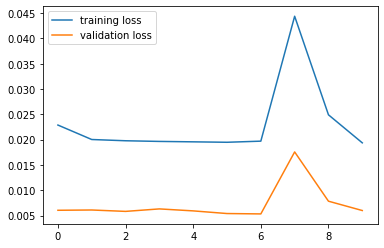

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

Load best model from checkpoint

In [17]:
best_speed_model = tf.keras.models.load_model('./checkpoints/speed/ckpt_7')

In [18]:
car12_X, car12_y, = generate_timeseries_data(df, {'2017':['12']}, history_size=150,
                                            target_size=1, col_name="speed_scaled",
                                            years=['2017'], train_ratio=1)

In [19]:
car12_pred = best_speed_model.predict(car12_X)

In [20]:
car12_pred.shape

(96750, 150, 1)

In [21]:
car12_y.shape

(96750,)

In [22]:
train_mae_loss = np.mean(np.abs(car12_pred - car12_X), axis=1)

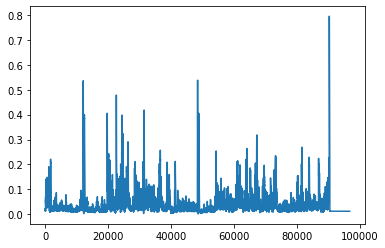

In [23]:
plt.plot(train_mae_loss)

In [24]:
export_path = 'serve_model/speed/1/'
best_speed_model.save('lstm-ad-speed_model.h5')

tf.keras.models.save_model(
    best_speed_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: serve_model/speed/1/assets


In [25]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['lstm_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: serving_default_lstm_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['time_distributed'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 150, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Nam